# Training from Images with Dueling Double Deep Q Network (DDDQN)

In this tutorial we show extend the features already introduced. We use again the interface for defining the neural network architecture with dictionaries, we use a preprocess functions for states, we use a clipping function for reward and finaly we show what you need to use images as inputs for an agent.

The environment selected for this tutorial is the implamentation by OpenAi Gym of the classic Atari game: space invaders.

In [1]:
from RL_Problem import rl_problem
from RL_Agent import dddqn_agent
from RL_Agent.base.utils.Memory.deque_memory import Memory as deq_m
import numpy as np
import matplotlib.pylab as plt
import gym
from RL_Agent.base.utils import agent_saver, history_utils
from RL_Agent.base.utils.networks import networks

2021-11-29 17:15:05.203004: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-11-29 17:15:05.224069: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2799925000 Hz
2021-11-29 17:15:05.224990: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55973e045810 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-29 17:15:05.225011: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-29 17:15:05.225095: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/serch/anaconda3/envs/capoir/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
 

We define the network architecture using the functin from "RL_Agent.base.utils.networks.networks" which return a dictionary. DDDQN has a particular network architecture that we have split in three subnetworks. The first network is the common network which recieves the input data. As you can see in the cell, we use convolutional layers to process the image input followed by one dense layer for the common network. Here, the network is splited in two:  the advantage network and the value network. Both subnetworks recieves the output of the common subnetwork and as their name said, they computes the "advantage" A(a,s) of take an action given an state and the "value" V(s) of being in a state.

In [2]:
net_architecture = networks.dueling_dqn_net(common_conv_layers=2,
                                            common_kernel_num=[32, 32],
                                            common_kernel_size=[3, 3],
                                            common_kernel_strides=[2, 2],
                                            common_conv_activation=['relu', 'relu'],
                                            common_dense_layers=1,
                                            common_n_neurons=[512],
                                            common_dense_activation=['relu'],
                                            
                                            advantage_dense_layers=2,
                                            advantage_n_neurons=[256, 128],
                                            advantage_dense_activation=['relu', 'relu'],

                                            value_dense_layers=2,
                                            value_n_neurons=[256, 128],
                                            value_dense_activation=['relu', 'relu'])

We want to preprocess the input images in order to reduce the dimensionality, crop the edges, convert to grayscale and normalize the pixel values. Here we define the function to do all this stuff.

In [3]:
def atari_preprocess(obs):
    # Crop and resize the image
    obs = obs[20:200:2, ::2]

    # Convert the image to grayscale
    obs = obs.mean(axis=2)

    # normalize between from 0 to 1
    obs = obs / 255.
    
    # Pass from 2D of shape (90, 80) to 3D array of shape (90, 80, 1)
    return obs


We also want to clip and normalize the reward function. The next funtion normalize the reward as: reward' = log(1+reward), and clip this value between [-1, 1].

In [4]:
# Diseñamos una función para normalizar o cortar el valor de recompensa original
def clip_norm_atari_reward(rew):
    return np.clip(np.log(1+rew), -1, 1)

We define the Gym environment.

In [5]:
environment = "SpaceInvaders-v0"
env = gym.make(environment)

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


Visualization of the original input and the preprocessed input.

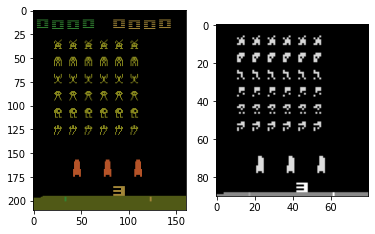

In [6]:
aux_obs = env.reset()
aux_prep_obs = atari_preprocess(aux_obs)
env.reset()

plt.figure()
plt.subplot(121)
plt.imshow(aux_obs)
plt.subplot(122)
plt.imshow(aux_prep_obs, cmap='gray')
plt.show()

Here we define the RL agent that we are going to use. In this case, we selected a DDQN agent which is an improvement over DQN.

The agent is defined configuring a few parameters:

* learning_rate: learning rate for training the neural network.
* batch_size: Size of the batches used for training the neural network. 
* epsilon: Determines the amount of exploration (float between [0, 1]). 0 -> Full Exploitation; 1 -> Full exploration.
* epsilon_decay: Decay factor of the epsilon. In each iteration we calculate the new epslon value as: epsilon' = epsilon * epsilon_decay.
* esilon_min: minimun value epsilon can reach during the training procedure.
* net_architecture: net architecture defined before.
* n_stack: number of stacked timesteps to form the state.
* img_input: boolean. Set to True where the states are images in form of 3D numpy arrays.
* state_size: tuple, size of the state.

Here we have two new parameters: 

1) img_input is just a boolean value that need to be setted as True where the input data are images.

2) state_size is the size of the input states. When is not defines the library use automaticaly the state size defined in the environmen but, as we changed it in the preprocessing, we need to set this value in an explicit way.

In [7]:
agent = dddqn_agent.Agent(learning_rate=1e-3,
                          batch_size=64,
                          epsilon=0.9,
                          epsilon_decay=0.999999,
                          epsilon_min=0.15,
                          net_architecture=net_architecture,
                          n_stack=5,
                          img_input=True,
                          state_size=(90, 80, 1)
                          )

Create a RL problem were the comunications between agent and environment are managed. In this case, we use the funcionality from "RL_Problem.rl_problem" which makes transparent to the user the selection of the matching problem. The function "Problem" automaticaly selects the problem based on the used agent.

In [8]:
problem = rl_problem.Problem(env, agent)

After defining the problem we are going to set the state preprocessing and reward normalization and clipping functions.

In [9]:
problem.preprocess = atari_preprocess
problem.clip_norm_reward = clip_norm_atari_reward

This environment consumes too memory when storing the states (images) for training the neural network. This is a good momment to introduce how to select the memory to use and its size.

DQN based methods are compatibles with all memories defined in RL_Agent.base.utils.Memory. Actually, you can find a deque memory, which is the standar memory for DQN methods and Prioritized Experience Replay (PER).

By default DDDQN uses deque memory. We only want to change the capacity of the experiences memory to not overflow the physic memory of the computer. 

In [10]:
# Seleccionamos el tamaño de la memoria
memory_max_len = 1000  # Indicamos la capacidad máxima de la memoria
problem.agent.set_memory(deq_m, memory_max_len)

Next step is solving the RL problem that we have define. Here we specify the number of episodes, the render boolean, the verbosity of the function, the skip_states parameter and additionaly if we want to render the environment afcter n iterations. 

When render is set to False we can specify the render_after parameter. The environement will be rendering after reach the specified number of iterations.


In [11]:
problem.solve(episodes=5, skip_states=3, render=False, render_after=3)

Episode:  1 Epochs:  758  Reward: 130.0 Smooth Reward: 130.0  Epsilon: 0.8998
Episode:  2 Epochs:  583  Reward: 50.0 Smooth Reward: 90.0  Epsilon: 0.8997
Episode:  3 Epochs:  633  Reward: 60.0 Smooth Reward: 80.0  Epsilon: 0.8995
Episode:  4 Epochs:  566  Reward: 95.0 Smooth Reward: 83.8  Epsilon: 0.8993


/home/serch/anaconda3/envs/capoir/lib/python3.7/site-packages/gym/envs/atari/environment.py:257: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  "We strongly suggest supplying `render_mode` when "


Episode:  5 Epochs:  1224  Reward: 255.0 Smooth Reward: 118.0  Epsilon: 0.8989


The next cell run n iterations in fully explorative mode to check the performance obtained by the agent. It will be rendered by default. The performance of the agent will be very bad, to reach aceptables performance we will need to run thousands of iterations for this environment.

In [12]:
problem.test(n_iter=2, render=True)

Test episode:  1 Epochs:  574  Reward: 30.0 Smooth Reward: 30.0  Epsilon: 0.8989
Test episode:  2 Epochs:  565  Reward: 95.0 Smooth Reward: 62.5  Epsilon: 0.8989


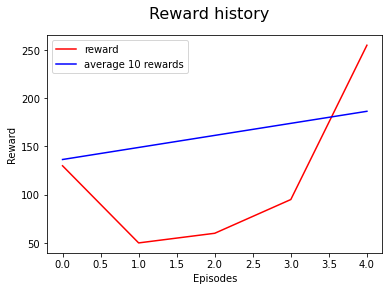

In [13]:
hist = problem.get_histogram_metrics()
history_utils.plot_reward_hist(hist, 10)

In [ ]:
agent_saver.save(agent, 'agent_dddqn.json')